#Import Libraries

In [1]:
import pandas as pd
import os
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import re
import shap # for SHAP summary - min. top 3 drivers

In [2]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Load Data

Source:
1. Resale Flat Prices: https://data.gov.sg/datasets?topics=housing&page=1&resultId=189
2. HDB Property Information: https://data.gov.sg/datasets/d_17f5382f26140b1fdae0ba2ef6239d2f/view
3. HDB Public Housing Building Under-Construction: https://data.gov.sg/datasets/d_930e662ac7e141fe3fd2a6efa5216902/view
4.

In [3]:
# List all files in the Colab directory
uploaded_files = os.listdir('/content/')
print("Files in Colab:", uploaded_files)

Files in Colab: ['.config', 'HDBResalePriceIndex1Q2009100Quarterly.csv', 'Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv', 'Resale flat prices based on registration date from Jan-2017 onwards.csv', 'Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv', 'HDBPropertyInformation.csv', 'Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv', 'Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv', 'sample_data']


In [4]:
# Load each CSV file individually
file1 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv')
file2 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv')
file3 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv')
file4 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv')
file5 = pd.read_csv('/content/Resale flat prices based on registration date from Jan-2017 onwards.csv')


In [5]:
# Print column names of each CSV
print("Columns in file1:", file1.columns)
print("Columns in file2:", file2.columns)
print("Columns in file3:", file3.columns)
print("Columns in file4:", file4.columns)
print("Columns in file5:", file5.columns)

Columns in file1: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file2: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file3: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file4: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')
Columns in file5: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale

file4 and file5 contain an extra column "remaining_lease"

In [6]:
# Add missing 'remaining_lease' column to file1, file2, and file3
for df in [file1, file2, file3]:
    df['remaining_lease'] = np.nan  # Assign NaN to missing column

In [7]:
# Concatenate all files
df = pd.concat([file1, file2, file3, file4, file5], ignore_index=True)

In [8]:
# Load additional datasets
property_info = pd.read_csv('/content/HDBPropertyInformation.csv')
resale_index = pd.read_csv('/content/HDBResalePriceIndex1Q2009100Quarterly.csv')

In [9]:
# Clean property info
property_info['blk_no'] = property_info['blk_no'].astype(str).str.strip().str.upper()
property_info['street'] = property_info['street'].astype(str).str.strip().str.upper()
df['block'] = df['block'].astype(str).str.strip().str.upper()
df['street_name'] = df['street_name'].astype(str).str.strip().str.upper()

# Merge property info into resale data
property_info.rename(columns={'blk_no': 'block', 'street': 'street_name'}, inplace=True)
df = df.merge(property_info[['block','street_name','year_completed','total_dwelling_units']],
               how='left', on=['block','street_name'])

In [10]:
# Display dataset info to confirm
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953065 entries, 0 to 953064
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   month                 953065 non-null  object 
 1   town                  953065 non-null  object 
 2   flat_type             953065 non-null  object 
 3   block                 953065 non-null  object 
 4   street_name           953065 non-null  object 
 5   storey_range          953065 non-null  object 
 6   floor_area_sqm        953065 non-null  float64
 7   flat_model            953065 non-null  object 
 8   lease_commence_date   953065 non-null  int64  
 9   resale_price          953065 non-null  float64
 10  remaining_lease       244015 non-null  object 
 11  year_completed        937053 non-null  float64
 12  total_dwelling_units  937053 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 94.5+ MB
None


In [11]:
# Check data
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_completed,total_dwelling_units
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN,NaN,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN,NaN,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN,NaN,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN,NaN,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN,1975.0,144.0


#Feature Engineering



## Time-Based Features
Convert transaction dates into year, month and quarter for trend detection



In [12]:
# Convert month to datetime format
df['month'] = pd.to_datetime(df['month'])

# Extract year, month, and quarter
df['year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month
df['quarter'] = df['month'].dt.quarter
df['quarter_label'] = df['year'].astype(str) + 'Q' + df['quarter'].astype(str)

# Compute building age
df['building_age'] = df['year'] - df['year_completed']
df['building_age'] = df['building_age'].fillna(df['building_age'].median())

# Drop the original month column (since we now have extracted features)
df.drop(columns=['month'], inplace=True)

print("✅ Time-based features added!")
display(df[['year', 'month_num', 'quarter']])


✅ Time-based features added!


,year,month_num,quarter
0,1990,1,1
1,1990,1,1
2,1990,1,1
3,1990,1,1
4,1990,1,1
...,...,...,...
953060,2025,2,1
953061,2025,4,2
953062,2025,4,2
953063,2025,5,2


In [13]:
df[['year', 'month_num', 'quarter']].sample(20)  # Show 20 random rows

,year,month_num,quarter
946286,2025,2,1
421216,2003,11,4
715354,2015,5,2
19480,1991,8,3
376873,2002,6,2
273350,1999,8,3
489121,2006,3,1
516524,2007,3,1
202636,1998,7,3
819368,2020,7,3


In [14]:
# Merge resale price index
resale_index.rename(columns={'quarter':'quarter_label'}, inplace=True)
df = df.merge(resale_index[['quarter_label','index']], how='left', on='quarter_label')
df['index'] = df['index'].fillna(method='ffill')

<ipython-input-14-cc5103062aef>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['index'] = df['index'].fillna(method='ffill')


##Location-Based Features
Encode town, street name using Label Encoding

In [15]:
print("Number of unique streets:", df['street_name'].nunique())
print("Top 10 most common streets:\n", df['street_name'].value_counts().head(10))

Number of unique streets: 592
Top 10 most common streets:
 street_name
YISHUN RING RD        17931
BEDOK RESERVOIR RD    14969
ANG MO KIO AVE 10     14045
ANG MO KIO AVE 3      12350
HOUGANG AVE 8          9534
TAMPINES ST 21         8415
BEDOK NTH ST 3         7684
BEDOK NTH RD           7593
ANG MO KIO AVE 4       7355
MARSILING DR           6765
Name: count, dtype: int64


Machine learning requires numerical data instead of text hence we use Label Encoding to replace each unique category with an integer

In [16]:
# Label Encoding for town and street_name
# Encode categorical variables
le_town = LabelEncoder()
le_street = LabelEncoder()

# Fit encoders
df['town'] = le_town.fit_transform(df['town'])
df['street_name'] = le_street.fit_transform(df['street_name'])

# Save mappings for later use
town_mapping = dict(zip(le_town.classes_, le_town.transform(le_town.classes_)))
street_mapping = dict(zip(le_street.classes_, le_street.transform(le_street.classes_)))

In [17]:
# Show full columns for town and street_name
display(df[['town', 'street_name']])


,town,street_name
0,0,14
1,0,14
2,0,14
3,0,14
4,0,14
...,...,...
953060,26,583
953061,26,583
953062,26,583
953063,26,583


In [18]:
df[['town', 'street_name']].sample(20)  # Show 20 random rows


,town,street_name
549313,23,471
452771,11,217
795062,4,170
724199,3,83
772018,18,380
69307,12,489
798652,0,17
525100,2,56
732521,24,502
797471,12,489


##Flat Characteristics
Include floor area, flat type, storey range as numerical inputs

In [19]:
# Label Encoding for categorical flat details
le_flat_type = LabelEncoder()
le_storey_range = LabelEncoder()
le_flat_model = LabelEncoder()

df['flat_type'] = le_flat_type.fit_transform(df['flat_type'])
df['storey_range'] = le_storey_range.fit_transform(df['storey_range'])
df['flat_model'] = le_flat_model.fit_transform(df['flat_model'])

In [20]:
# Check final dataset structure
print("✅ Flat characteristic features processed!")
display(df[['flat_type', 'storey_range', 'flat_model', 'floor_area_sqm']])

✅ Flat characteristic features processed!


,flat_type,storey_range,flat_model,floor_area_sqm
0,0,5,7,31.0
1,0,2,7,31.0
2,0,5,7,31.0
3,0,4,7,31.0
4,2,2,20,73.0
...,...,...,...,...
953060,5,5,15,146.0
953061,5,4,5,142.0
953062,5,2,15,146.0
953063,5,2,5,142.0


In [21]:
# Add interaction features
df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']

df['flat_storey_combo'] = df['flat_type'].astype(str) + "_" + df['storey_range'].astype(str)
df['town_model_combo'] = df['town'].astype(str) + "_" + df['flat_model'].astype(str)

# Encode new combo features
le_flat_storey = LabelEncoder()
le_town_model = LabelEncoder()

df['flat_storey_combo'] = le_flat_storey.fit_transform(df['flat_storey_combo'])
df['town_model_combo'] = le_town_model.fit_transform(df['town_model_combo'])

print("✅ Added new interaction features!")
display(df[['price_per_sqm', 'flat_storey_combo', 'town_model_combo']].sample(10))

✅ Added new interaction features!


,price_per_sqm,flat_storey_combo,town_model_combo
271112,3097.826087,62,105
97047,1731.958763,59,264
664940,6355.932203,34,166
491376,2485.294118,34,320
467338,3618.181818,72,14
143711,3223.140496,75,293
196375,2352.941176,35,173
358388,2537.190083,83,57
31994,1175.824176,60,5
680306,6722.222222,59,201


# XGBoost Model

Train a regression model to predict resale prices.

## XGBoost Training

In [22]:
# Define target variable (y)
y = df['resale_price']

# Define features (X) - Drop columns that are not useful for prediction
X = df.drop(columns=['resale_price','block','price_per_sqm','flat_storey_combo','town_model_combo','quarter_label'])

In [23]:
# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data split completed!")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

✅ Data split completed!
Training samples: 762452, Testing samples: 190613


In [24]:
# Parse to convert everything into months/years precisely
def parse_remaining_lease(lease_str):
    if pd.isnull(lease_str):
        return np.nan
    # If it's already a number (int or float), just return it
    if isinstance(lease_str, (int, float)):
        return lease_str
    # Otherwise parse the string
    lease_str = lease_str.lower()
    years = months = 0
    match = re.findall(r'(\d+)\s*years?|(\d+)\s*months?', lease_str)
    for m in match:
        if m[0]:
            years = int(m[0])
        if m[1]:
            months = int(m[1])
    return years + (months / 12)


# Apply to both train and test sets
X_train['remaining_lease'] = X_train['remaining_lease'].apply(parse_remaining_lease)
X_test['remaining_lease'] = X_test['remaining_lease'].apply(parse_remaining_lease)

In [25]:
# Define XGBoost model
model = XGBRegressor(
    n_estimators=1200,  # Number of trees
    learning_rate=0.05,  # Step size for updates
    max_depth=11,  # Depth of each tree
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=0.7, # L2 regularization (stronger penalty)
    reg_alpha=0.3, # L1 regularization (encourages sparsity)
    random_state=42
)

In [26]:
# Train the model
model.fit(X_train, y_train)

print("✅ XGBoost Model Training Completed!")

✅ XGBoost Model Training Completed!


In [27]:
# Save model as a binary file
model.save_model("xgboost_market_trend_analysis.json")  # Saves the model in JSON format

## Evaluate Model

- MAPE (Mean Absolute Percentage Error): Avg. % difference between predicted and actual. Target ≤ 15%.
- PICP (Prediction Interval Coverage Probability): % of actual values within prediction intervals. Target ≥ 90%.
- RMSE (Root Mean Squared Error): Measures typical prediction error magnitude. Target ≤ $100,000.
- SHAP: Shows most important features influencing the prediction.

In [36]:
# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"📉 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Calculate PICP (Prediction Interval Coverage Probability)
y_test_array = np.array(y_test)
residuals = np.abs(y_test_array - y_pred)
interval = 2.3 * np.std(residuals)
covered = np.sum((y_test_array >= y_pred - interval) & (y_test_array <= y_pred + interval))
picp = covered / len(y_test_array) * 100
print(f"📈 Prediction Interval Coverage Probability (PICP): {picp:.2f}%")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"📉 Mean Absolute Error: {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.2f}")

📉 Mean Absolute Percentage Error (MAPE): 4.68%
📈 Prediction Interval Coverage Probability (PICP): 91.76%
📉 Mean Absolute Error: 13024.01
📉 Root Mean Squared Error (RMSE): 18891.20


MAE Value = Model's predictions are off by $Value

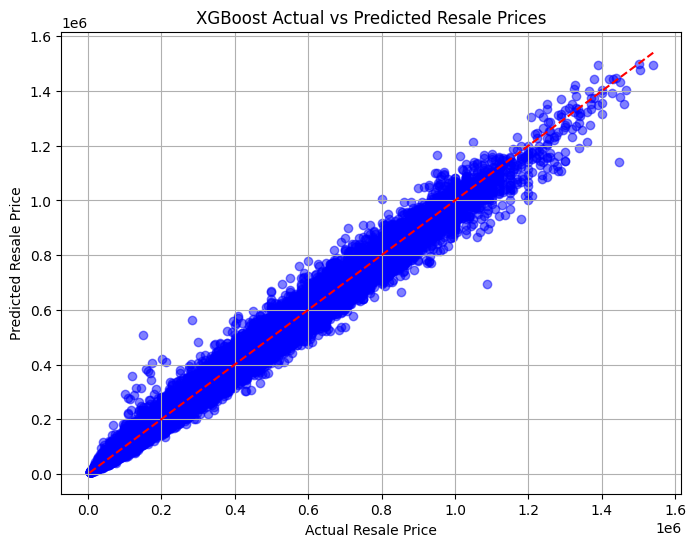

In [29]:
# Scatter plot for visual evaluation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("XGBoost Actual vs Predicted Resale Prices")
plt.grid()
plt.show()

In [30]:
# SHAP summary
#explainer = shap.Explainer(model)
#shap_values = explainer(X_test)
#print("📊 SHAP Summary Plot (Top 3 Features):")
#shap.summary_plot(shap_values, X_test, max_display=3)

In [31]:
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_test)
#print("📊 SHAP Summary Plot (Top 3 Features):")
#shap.summary_plot(shap_values, X_test, max_display=3)

X_sample: Randomly selects 300 samples from test set (to make SHAP faster and lighter to compute)

shap.TreeExplainer(model): Builds a SHAP explainer for the XGBoost model (tree-based explainer is much faster than generic explainer)

explainer.shap_values(X_sample): Computes the SHAP values for each feature in each sample

shap.summary_plot(shap_values, X_sample, max_display=5): Displays a summary plot showing which features are most important and how they affect the prediction

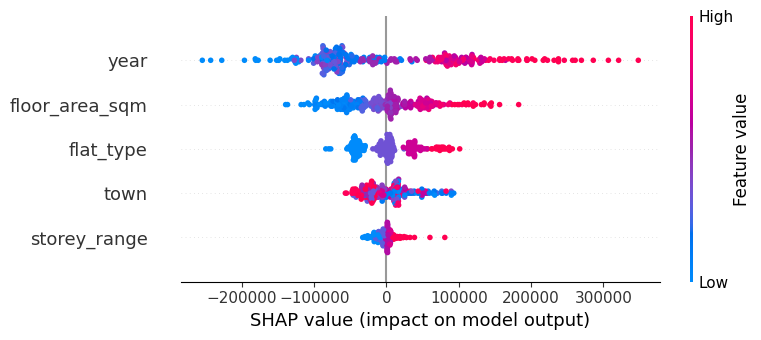

In [33]:
# SHAP summary using a sample of test data
X_sample = X_test.sample(300, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, max_display=5)


What is SHAP?

SHAP (SHapley Additive exPlanations) breaks down each prediction into:
"How much did each feature push the prediction up or down?"

1. Positive SHAP value -> pushes price higher
2. Negative SHAP value -> pushes price lower

Y-axis (Features): Top 5 most important drivers, ranked by total impact on model prediction

X-axis (SHAP value): How much the feature is affecting resale price (in dollar value)

Colour (Feature value): Red = high feature value, Blue = low feature value

Based on the output,

1. year - Later years (red dots) strongly increase resale price (right side), older years (blue dots) decrease price (left side)

2. floor_area_sqm - Bigger units (red) increase price; smaller units (blue) lower price

3. flat_type - Larger flat types (executive, 5-room) tend to push prices up

4. town - Certain towns have consistently higher or lower prices (depending on demand/location)

5. storey_range - Higher floors may increase resale value slightly, but not as strongly as the other features